In [1]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2
from psycopg2.extras import RealDictCursor

DEC2FLOAT = psycopg2.extensions.new_type(
    psycopg2.extensions.DECIMAL.values,
    "DEC2FLOAT",
    lambda value, curs: float(value) if value is not None else None,
)

psycopg2.extensions.register_type(DEC2FLOAT)

plt.style.use("ggplot")
pl.Config(tbl_rows=20)

In [2]:
connection = psycopg2.connect(
    database="test_crypto_pricing",
    user="postgres",
    password="admin",
    host="localhost",
    port=5432,
)

In [3]:
cur = connection.cursor(cursor_factory=RealDictCursor)
cur.execute(open("python_sql/depth.sql").read())

db_extract = cur.fetchall()

df = pl.DataFrame(db_extract)

In [4]:
book = df.pivot(
    index=["depth_update_id", "event_time", "symbol"],
    on=["side", "level_id"],
    values=["price", "quantity"],
)

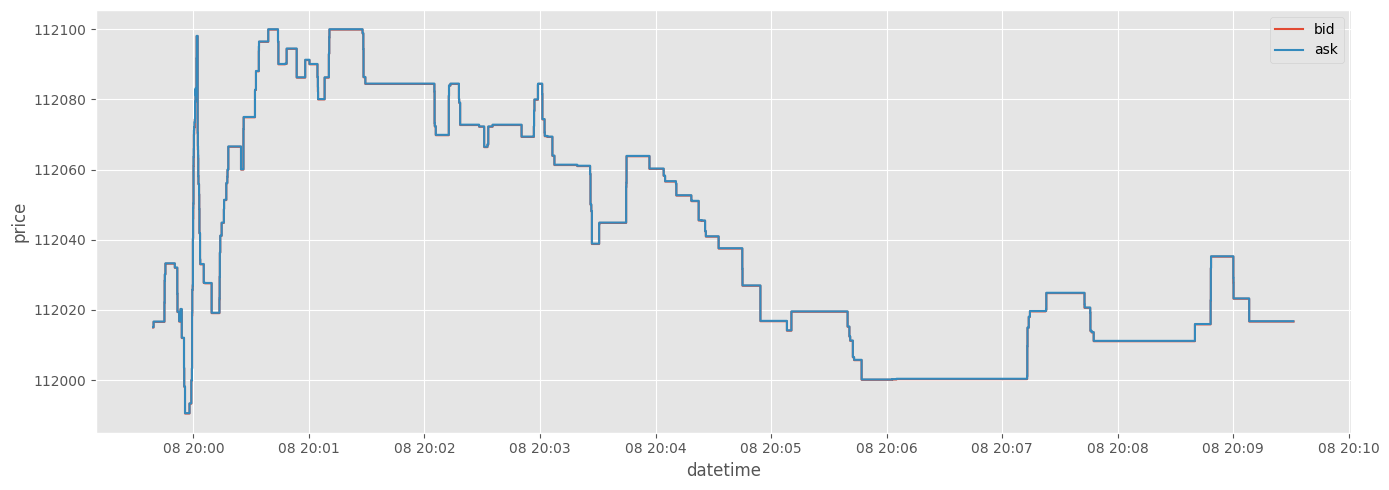

In [5]:
top_of_book = book.select(["event_time", "price_{1,1}", "price_{-1,1}"])

fig, ax = plt.subplots(figsize=(14, 5))

plt.step(top_of_book["event_time"], top_of_book["price_{1,1}"], label="bid")
plt.step(top_of_book["event_time"], top_of_book["price_{-1,1}"], label="ask")

ax.set_ylabel("price")
ax.set_xlabel("datetime")
ax.legend()

fig.tight_layout()

In [6]:
book.head(5)

depth_update_id,event_time,symbol,"price_{1,15}","price_{1,10}","price_{1,14}","price_{1,13}","price_{1,12}","price_{1,8}","price_{1,11}","price_{1,7}","price_{1,4}","price_{1,9}","price_{1,1}","price_{1,6}","price_{1,2}","price_{1,5}","price_{1,3}","price_{1,16}","price_{1,17}","price_{1,18}","price_{1,19}","price_{1,20}","price_{-1,3}","price_{-1,7}","price_{-1,1}","price_{-1,13}","price_{-1,12}","price_{-1,11}","price_{-1,10}","price_{-1,9}","price_{-1,8}","price_{-1,5}","price_{-1,4}","price_{-1,6}","price_{-1,2}","price_{-1,14}",…,"quantity_{1,13}","quantity_{1,12}","quantity_{1,8}","quantity_{1,11}","quantity_{1,7}","quantity_{1,4}","quantity_{1,9}","quantity_{1,1}","quantity_{1,6}","quantity_{1,2}","quantity_{1,5}","quantity_{1,3}","quantity_{1,16}","quantity_{1,17}","quantity_{1,18}","quantity_{1,19}","quantity_{1,20}","quantity_{-1,3}","quantity_{-1,7}","quantity_{-1,1}","quantity_{-1,13}","quantity_{-1,12}","quantity_{-1,11}","quantity_{-1,10}","quantity_{-1,9}","quantity_{-1,8}","quantity_{-1,5}","quantity_{-1,4}","quantity_{-1,6}","quantity_{-1,2}","quantity_{-1,14}","quantity_{-1,15}","quantity_{-1,16}","quantity_{-1,17}","quantity_{-1,18}","quantity_{-1,19}","quantity_{-1,20}"
i64,"datetime[μs, UTC]",str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,2025-09-08 19:59:39.154 UTC,"""BTCUSDT""",112012.3,112013.4,112012.7,112012.9,112013.0,112013.6,112013.3,112014.1,112014.6,112013.5,112015.0,112014.4,112014.9,112014.5,112014.8,112012.1,112012.0,112011.8,112011.6,112011.5,112015.3,112016.7,112015.1,112017.7,112017.6,112017.2,112017.1,112017.0,112016.8,112015.9,112015.4,112016.5,112015.2,112018.0,…,0.338,0.074,0.051,1.083,0.045,2.912,0.001,19.149,1.13,0.001,0.003,0.001,0.001,1.356,0.03,0.006,0.029,0.002,0.001,6.597,0.002,0.002,0.001,0.037,0.002,0.004,0.002,0.104,0.002,0.005,0.007,0.002,0.004,0.001,0.023,0.002,0.133
2,2025-09-08 19:59:39.256 UTC,"""BTCUSDT""",112012.7,112013.4,112012.8,112012.9,112013.0,112013.6,112013.3,112014.1,112014.6,112013.5,112015.0,112014.4,112014.9,112014.5,112014.7,112012.3,112012.1,112012.0,112011.6,112011.5,112015.3,112016.8,112015.1,112018.0,112017.7,112017.6,112017.2,112017.1,112017.0,112016.5,112015.9,112016.7,112015.2,112018.2,…,0.338,0.074,0.051,1.085,0.044,0.826,0.001,20.792,1.13,0.001,0.005,0.001,0.002,0.003,1.356,0.006,0.029,0.002,0.004,6.598,0.01,0.002,0.002,0.003,0.037,0.002,0.002,0.002,0.028,0.005,0.002,0.004,0.001,0.023,0.01,0.122,0.002
3,2025-09-08 19:59:39.364 UTC,"""BTCUSDT""",112012.7,112013.4,112012.8,112012.9,112013.0,112013.6,112013.3,112014.1,112014.6,112013.5,112015.0,112014.4,112014.9,112014.5,112014.7,112012.3,112012.1,112012.0,112011.6,112011.5,112015.3,112016.8,112015.1,112018.0,112017.7,112017.6,112017.2,112017.1,112017.0,112016.5,112015.9,112016.7,112015.2,112018.2,…,0.338,0.074,0.051,1.085,0.044,0.826,0.001,20.146,1.13,0.001,0.003,0.001,0.002,0.003,1.356,0.006,0.029,0.002,0.006,6.602,0.007,0.005,0.002,0.001,0.037,0.002,0.002,0.002,0.028,0.005,0.002,0.004,0.001,0.023,0.01,0.122,0.002
4,2025-09-08 19:59:39.472 UTC,"""BTCUSDT""",112013.8,112014.8,112014.3,112014.4,112014.6,112015.1,112014.7,112015.2,112016.3,112015.0,112016.6,112015.3,112016.5,112015.9,112016.4,112013.6,112013.4,112013.3,112013.0,112012.7,112017.1,112018.2,112016.7,112019.6,112019.5,112019.3,112018.9,112018.5,112018.3,112017.7,112017.2,112018.0,112016.8,112019.7,…,1.2,0.826,0.359,0.001,2.129,0.044,1.158,33.105,0.001,0.001,0.001,0.001,0.05,0.316,1.085,0.002,0.945,0.037,0.002,7.468,0.011,0.003,0.002,0.002,0.001,0.004,0.002,0.003,0.007,0.005,0.02,0.005,0.002,0.025,0.031,0.003,0.002
5,2025-09-08 19:59:39.575 UTC,"""BTCUSDT""",112014.0,112014.7,112014.3,112014.4,112014.5,112015.0,112014.6,112015.1,112016.3,112014.8,112016.6,112015.2,112016.5,112016.2,112016.4,112013.8

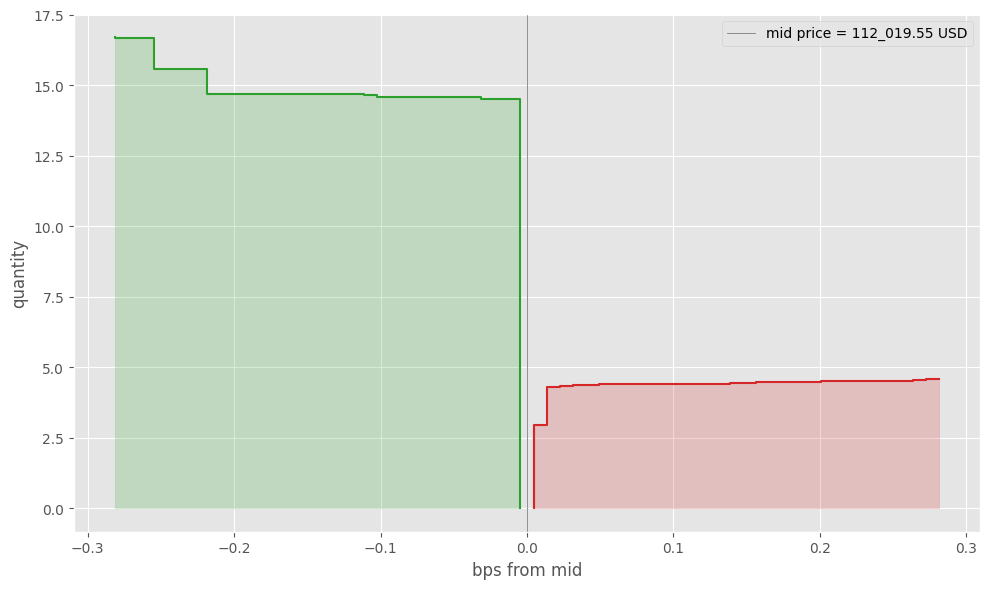

In [7]:
orderbook_depth = (
    df.filter([pl.col("depth_update_id") == 3300])
    .sort(by=["level_id"], descending=False)
    .with_columns([pl.col("quantity").cum_sum().over("side").alias("cumulative_depth")])
)

orderbook_oos = orderbook_depth.filter(pl.col("level_id") == 1).with_columns(
    [
        pl.lit(0).alias("level_id").cast(pl.Int64),
        pl.lit(0).alias("quantity").cast(pl.Float64),
        pl.lit(0).alias("cumulative_depth").cast(pl.Float64),
    ]
)

mid_price = orderbook_oos["price"].sum() / 2

orderbook_depth = (
    pl.concat([orderbook_depth, orderbook_oos])
    .with_columns(
        [((pl.col("price") - mid_price) / mid_price * 10_000).alias("bps_from_mid")]
    )
    .sort(by=["price"])
)

fig, ax = plt.subplots(figsize=(10, 6))
for side, c in zip([1, -1], ["tab:green", "tab:red"]):
    side_plot_data = orderbook_depth.filter([pl.col("side") == side])

    ax.step(
        side_plot_data["bps_from_mid"],
        side_plot_data["cumulative_depth"],
        where="pre",
        c=c,
    )
    ax.fill_between(
        side_plot_data["bps_from_mid"],
        y1=side_plot_data["cumulative_depth"],
        step="pre",
        color=c,
        alpha=0.2,
    )

ax.axvline(0, lw=0.6, label=f"mid price = {mid_price:_} USD", color="tab:grey")

ax.set_xlabel("bps from mid")
ax.set_ylabel("quantity")
ax.legend()

fig.tight_layout()